In [729]:
import os
import glob
from pathlib import Path
import ssl
import random
from datetime import datetime
import time
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.util import random_noise

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid

import torch.nn as nn
from torch import flatten


# if using remote server
current_path = os.path.basename(os.path.normpath(os.getcwd()))
DIR = "digit-classifier-pytorch"
if(current_path != DIR):
	os.chdir(DIR)
	print("Changed directory into: "+DIR)

BATCH_SIZE = 128
SHUFFLE = True
NUM_WORKERS = 0
PIN_MEMORY = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, torch.cuda.get_device_name(0))

cuda:0 NVIDIA GeForce RTX 3060 Ti


In [730]:
# get dataset
train_ds = datasets.MNIST(
	root="data",
	train=True,
	download=True,
)

val_ds = datasets.MNIST(
	root="data",
	train=False,
	download=True,
)

train_images = train_ds.data.numpy()
train_labels = train_ds.targets.numpy()

val_images = val_ds.data.numpy()
val_labels = val_ds.targets.numpy()

In [731]:
# image loader
class PreAugmentDataset(Dataset):
	def __init__(self, images, labels, transform=None):
		self.transform = transform
		self.images = images.copy()
		self.labels = labels.copy()

		self.images = np.expand_dims(self.images,1) # make format (size, channels, width, height)

		self.images = torch.tensor(self.images, dtype=torch.float32) / 255. # to tensor
		self.images = torch.clamp(self.images, 0., 1.) # clamp between 0 and 1

		self.labels = torch.tensor(self.labels) # to tensor

		print(self.images.shape)

	def applyTransforms(self, transforms):
		for i, img in enumerate(self.images):
			self.images[i] = transforms(img)

		# salt and pepper noise
		# level_of_noise = 0.5
		# self.images = self.images + level_of_noise * np.random.normal(loc=0.0, scale=1.0, size=self.images.shape)
		
		self.images = torch.clamp(self.images, 0., 1.)

	def __len__(self):
		return len(self.labels)

	def __getitem__(self, idx):
		image = self.images[idx]
		label = self.labels[idx]
		return image, label
		

train_ds = PreAugmentDataset(train_images, train_labels)
val_ds = PreAugmentDataset(val_images, val_labels)

train_loader = torch.utils.data.DataLoader(
	train_ds, 
	batch_size = BATCH_SIZE, 
	shuffle = SHUFFLE, 
	num_workers=NUM_WORKERS, 
	pin_memory=PIN_MEMORY
)
val_loader = torch.utils.data.DataLoader(
	val_ds, 
	batch_size = BATCH_SIZE, 
	shuffle = SHUFFLE, 
	num_workers=NUM_WORKERS, 
	pin_memory=PIN_MEMORY
)

print('Training set has {} instances'.format(len(train_ds)))
print('Validation set has {} instances'.format(len(val_ds)))

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
Training set has 60000 instances
Validation set has 10000 instances


In [732]:
# image transformations

all_transforms = transforms.Compose([
	#transforms.Normalize([0.5], [0.5]),
	#transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.8,1.2))
])

train_ds.applyTransforms(all_transforms)
print("train_ds done")
val_ds.applyTransforms(all_transforms)
print("val_ds done")

train_ds done
val_ds done


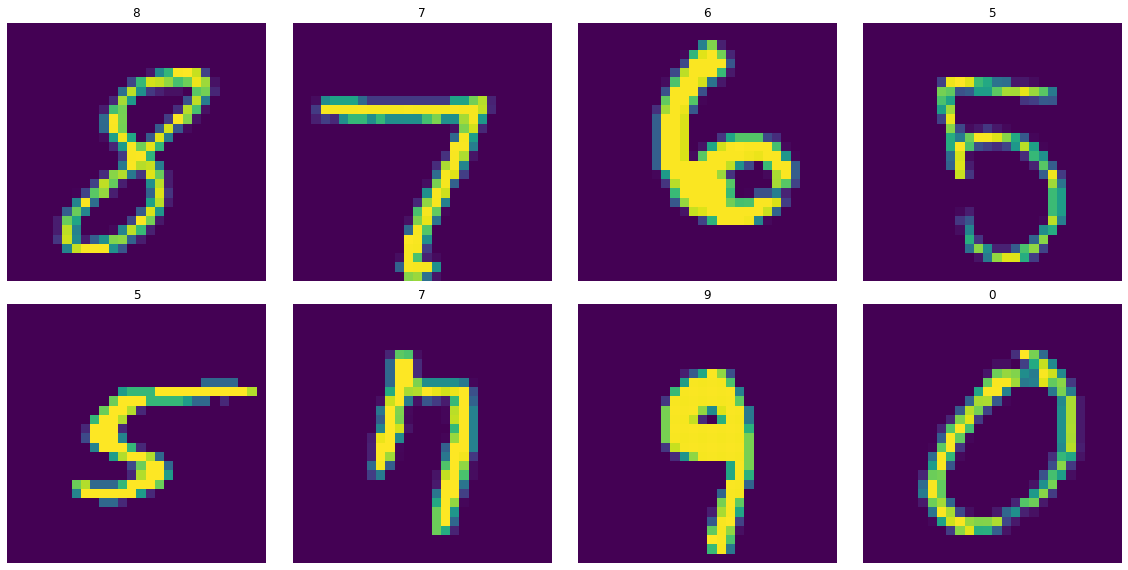

In [733]:
# plot images
fig, axes = plt.subplots(2,4, figsize=(16, 8))

first_batch = next(iter(train_loader))
images = first_batch[0]
labels = first_batch[1]

for i, ax in enumerate(axes.flat):
	ax.imshow(images[i].squeeze())
	ax.set_title(labels[i].item())
	ax.axis("off")

plt.tight_layout()
plt.show()

In [734]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# create model
class ClassifierModel(nn.Module):
	def __init__(self):
		super(ClassifierModel, self).__init__()

		self.conv_block1 = nn.Sequential(
			nn.Conv2d(in_channels=1, out_channels=128, kernel_size=(5,5), padding="same"),
			nn.ReLU(),
			nn.MaxPool2d((2,2)),

			nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding="same"),
			nn.ReLU(),
			nn.MaxPool2d((2,2)),

			nn.Dropout(0.5),
		)

		self.conv_block2 = nn.Sequential(
			nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding="same"),
			nn.ReLU(),
			nn.MaxPool2d((2,2)),

			nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), padding="same"),
			nn.ReLU(),
			nn.MaxPool2d((2,2)),

			nn.Dropout(0.5),
		)

		# flatten

		self.seq2 = nn.Sequential( # fully connect
			nn.Linear(in_features=512, out_features=1024),
			nn.ReLU(),
			nn.Linear(in_features=1024, out_features=512),
			nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(in_features=512, out_features=10),
			nn.LogSoftmax(dim=1)
		)

	def forward(self, x):
		x = self.conv_block1(x) # conv blocks
		x = self.conv_block2(x)
		x = flatten(x, 1) # flatten
		output = self.seq2(x) # fully connected
		return output

	def training_step(self, batch):
		images = batch[0].to(device, non_blocking=True)
		labels = batch[1].to(device, non_blocking=True)
		self.optimizer.zero_grad()
		out = self(images)                  # Generate predictions
		loss = self.criterion(out, labels)
		loss.backward()
		self.optimizer.step()
	
	def validation_step(self, batch):
		images = batch[0].to(device, non_blocking=True)
		labels = batch[1].to(device, non_blocking=True)
		out = self(images)
		loss = self.criterion(out, labels)
		acc = accuracy(out, labels)           # Calculate accuracy
		return {'val_loss': loss, 'val_acc': acc}
		
	def validation_epoch_end(self, outputs):
		batch_losses = [x['val_loss'] for x in outputs]
		epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
		batch_accs = [x['val_acc'] for x in outputs]
		epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
		return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
	
	def epoch_end(self, epoch, result, ttime=0, vtime=0):
		print("Epoch [{}]: train time: {:.1f}s, val time: {:.1f}s, val_loss: {:.3f}, val_acc: {:.3f}%".format(epoch+1, ttime, vtime, result['val_loss']*100, result['val_acc']*100))

In [735]:
def evaluate(model, val_loader):
	with torch.no_grad():
		outputs = [model.validation_step(batch) for batch in val_loader]
		return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader):
	history = []
	for epoch in range(epochs):
		t0 = time.time()
		# Training Phase 
		model.train()
		for b, batch in enumerate(train_loader):
			model.training_step(batch)
			if b % 10 == 0:
				print(f'{b}/{len(train_loader)}', end="\r")
		t1 = time.time()
		# Validation phase
		with torch.no_grad():
			model.eval()
			result = evaluate(model, val_loader)
			model.epoch_end(epoch, result, (t1 - t0), (time.time() - t1))
			history.append(result)
	return history

In [736]:
# Model (on GPU)
model = ClassifierModel()

model.to(device, non_blocking=True)
model.optimizer = torch.optim.Adam(model.parameters(), 0.0001) # lr
model.criterion = nn.CrossEntropyLoss()

# test validation dataset
history = []
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3024697303771973, 'val_acc': 0.10917721688747406}]

In [737]:
history += fit(25, model, train_loader, val_loader)

Epoch [1]: train time: 5.1s, val time: 0.5s, val_loss: 11.830, val_acc: 96.242%
Epoch [2]: train time: 5.1s, val time: 0.5s, val_loss: 5.943, val_acc: 98.111%
Epoch [3]: train time: 5.1s, val time: 0.5s, val_loss: 4.788, val_acc: 98.309%
Epoch [4]: train time: 5.1s, val time: 0.5s, val_loss: 4.011, val_acc: 98.705%
Epoch [5]: train time: 5.1s, val time: 0.5s, val_loss: 3.462, val_acc: 98.873%
Epoch [6]: train time: 5.1s, val time: 0.5s, val_loss: 3.211, val_acc: 99.001%
Epoch [7]: train time: 5.1s, val time: 0.5s, val_loss: 2.459, val_acc: 99.209%
Epoch [8]: train time: 5.1s, val time: 0.5s, val_loss: 2.836, val_acc: 99.120%
Epoch [9]: train time: 5.1s, val time: 0.5s, val_loss: 2.299, val_acc: 99.110%
Epoch [10]: train time: 5.1s, val time: 0.5s, val_loss: 2.243, val_acc: 99.189%
Epoch [11]: train time: 5.1s, val time: 0.5s, val_loss: 2.382, val_acc: 99.179%
Epoch [12]: train time: 5.2s, val time: 0.5s, val_loss: 2.084, val_acc: 99.318%
Epoch [13]: train time: 5.1s, val time: 0.5s, va

KeyboardInterrupt: 

In [ ]:
f_history = {"val_loss": [], "val_acc": []}
for epoch in history:
	f_history['val_loss'].append(epoch['val_loss'])
	f_history['val_acc'].append(epoch['val_acc'])
history = f_history

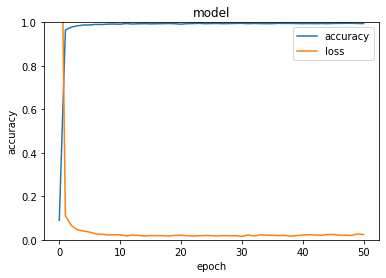

In [ ]:
plt.plot(history['val_acc'])
plt.plot(history['val_loss'])
plt.title('model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['accuracy', 'loss'], loc='best')
plt.show()

In [ ]:
# del model
# torch.cuda.synchronize()
# torch.cuda.empty_cache()
# gc.collect()